<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Predicting "Greenness" Of Content

---

This dataset comes from [stumbleupon](https://www.stumbleupon.com/), a web page recommender and was made available [here](https://www.kaggle.com/c/stumbleupon/download/train.tsv)

A description of the columns is below

FieldName|Type|Description
---------|----|-----------
url|string|Url of the webpage to be classified
urlid|integer| StumbleUpon's unique identifier for each url
boilerplate|json|Boilerplate text
alchemy_category|string|Alchemy category (per the publicly available Alchemy API found at www.alchemyapi.com)
alchemy_category_score|double|Alchemy category score (per the publicly available Alchemy API found at www.alchemyapi.com)
avglinksize| double|Average number of words in each link
commonLinkRatio_1|double|# of links sharing at least 1 word with 1 other links / # of links
commonLinkRatio_2|double|# of links sharing at least 1 word with 2 other links / # of links
commonLinkRatio_3|double|# of links sharing at least 1 word with 3 other links / # of links
commonLinkRatio_4|double|# of links sharing at least 1 word with 4 other links / # of links
compression_ratio|double|Compression achieved on this page via gzip (measure of redundancy)
embed_ratio|double|Count of number of <embed> usage
frameBased|integer (0 or 1)|A page is frame-based (1) if it has no body markup but have a frameset markup
frameTagRatio|double|Ratio of iframe markups over total number of markups
hasDomainLink|integer (0 or 1)|True (1) if it contains an <a> with an url with domain
html_ratio|double|Ratio of tags vs text in the page
image_ratio|double|Ratio of <img> tags vs text in the page
is_news|integer (0 or 1) | True (1) if StumbleUpon's news classifier determines that this webpage is news
lengthyLinkDomain| integer (0 or 1)|True (1) if at least 3 <a> 's text contains more than 30 alphanumeric characters
linkwordscore|double|Percentage of words on the page that are in hyperlink's text
news_front_page| integer (0 or 1)|True (1) if StumbleUpon's news classifier determines that this webpage is front-page news
non_markup_alphanum_characters|integer| Page's text's number of alphanumeric characters
numberOfLinks|integer Number of <a>|markups
numwords_in_url| double|Number of words in url
parametrizedLinkRatio|double|A link is parametrized if it's url contains parameters or has an attached onClick event
spelling_errors_ratio|double|Ratio of words not found in wiki (considered to be a spelling mistake)
label|integer (0 or 1)|User-determined label. Either evergreen (1) or non-evergreen (0); available for train.tsv only

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
 
plt.style.use('ggplot')
sns.set(font_scale=1.5)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import json

# set max printout options for pandas:
pd.options.display.max_columns = 50
pd.options.display.max_colwidth = 300

### 1. Load the data
- Note it is a `.tsv` file and has a tab separator instead of comma.
- Clean the `is_news` column.
- Make two new columns, `title` and `body`, from the `boilerplate` column.

> **Note:** The `boilerplate` column is in json dictionary format. You can use the `json.loads()` function from the `json` module to convert this into a python dictionary.

In [2]:
evergreen_tsv = '../../../../../resource-datasets/stumbleupon/stumbleupon.tsv'

In [3]:
data = pd.read_csv(evergreen_tsv, sep='\t', na_values={'is_news' : '?'}).fillna(0)

# Extract the title and body from the boilerplate JSON text
data['title'] = data.boilerplate.map(lambda x: json.loads(x).get('title', ''))
data['body'] = data.boilerplate.map(lambda x: json.loads(x).get('body', ''))

### 2. What are 'evergreen' sites?
- These are websites that are always relevant like recipes or reviews (as opposed to current events).
- Stored as a binary indicator in the `label` column.
- Look at some examples.

In [4]:
data[['title', 'label']].head()

,title,label
0,"IBM Sees Holographic Calls Air Breathing Batteries ibm sees holographic calls, air-breathing batteries",0
1,"The Fully Electronic Futuristic Starting Gun That Eliminates Advantages in Races the fully electronic, futuristic starting gun that eliminates advantages in races the fully electronic, futuristic starting gun that eliminates advantages in races",1
2,Fruits that Fight the Flu fruits that fight the flu | cold & flu | men's health,1
3,10 Foolproof Tips for Better Sleep,1
4,The 50 Coolest Jerseys You Didn t Know Existed coolest jerseys you haven't seen,0


### 3. Does being a news site affect evergreenness?

#### 3.A Investigate with plots/EDA.

In [5]:
data.groupby('is_news')[['label']].mean()

,label
is_news,
0.0,0.507562
1.0,0.516916


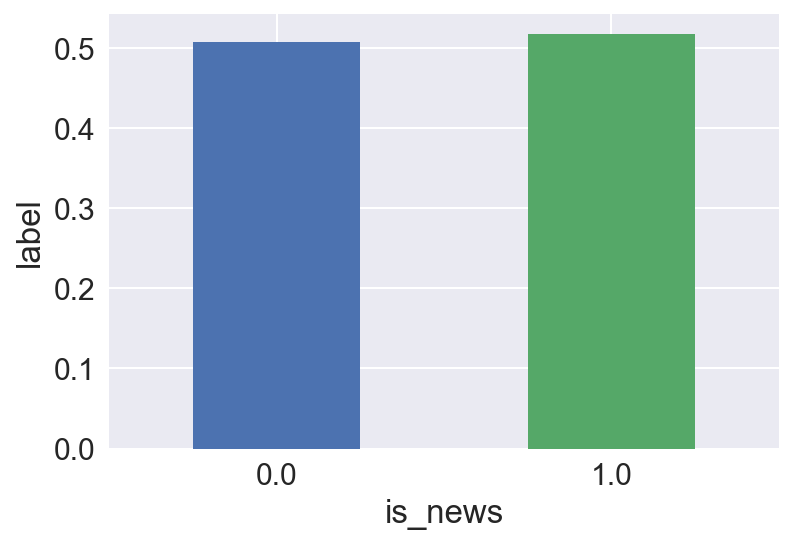

In [6]:
data.groupby('is_news')[['label']].mean().plot(kind='bar',y='label',rot=0, legend=None)
plt.ylabel('label')
plt.show()

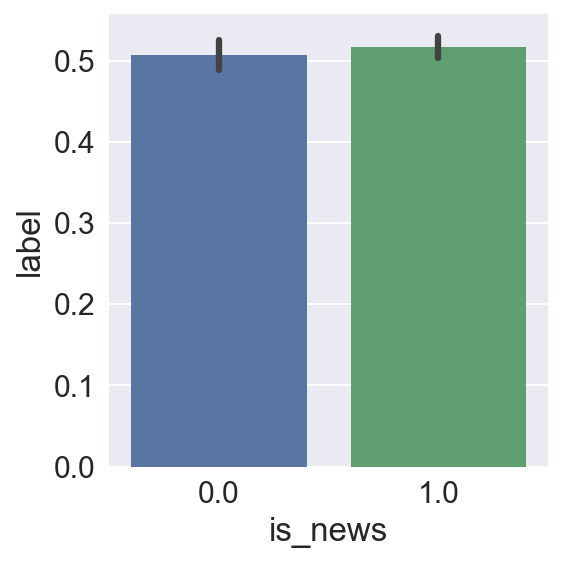

In [7]:
g = sns.factorplot(x='is_news', y='label', data=data,kind='bar')
plt.show()

#### 3.B Test the hypothesis with a logistic regression using statsmodels.

> **Hint:** The `sm.logit` function from `statsmodels.formula.api` will perform a logistic regression using a formula string.

In [8]:
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)
import statsmodels.formula.api as smf

news_data = data[['label','is_news']]

news_model = smf.logit("label ~ is_news", data=news_data).fit()
news_model.summary()

Optimization terminated successfully.
         Current function value: 0.692751
         Iterations 3


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  label   No. Observations:                 7395
Model:                          Logit   Df Residuals:                     7393
Method:                           MLE   Df Model:                            1
Date:                Tue, 17 Jul 2018   Pseudo R-squ.:               5.980e-05
Time:                        11:11:24   Log-Likelihood:                -5122.9
converged:                       True   LL-Null:                       -5123.2
                                        LLR p-value:                    0.4337
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0303      0.038      0.806      0.420      -0.043       0.104
is_news        0.0374      0.048      0.783      0.434      -0.056       0.131
==============================================================================
"""

In [9]:
1./(1+np.exp(-(news_model.params.Intercept+news_model.params.is_news)))

0.5169156414762741

In [10]:
1./(1+np.exp(-(news_model.params.Intercept)))

0.5075624340485407

In [11]:
news_model.predict(news_data)[:10]

0    0.516916
1    0.516916
2    0.516916
3    0.516916
4    0.516916
5    0.507562
6    0.516916
7    0.507562
8    0.516916
9    0.507562
dtype: float64

#### 3.C Interpret the results of your model.

The effect of being a news site on evergreen status is insignificant.
More formally, we would accept the null hypothesis that news sites and
non-news sites have equal probability of being evergreen.

### 4. Does the website category affect evergreenness?

#### 4.A Investigate with plots/EDA.

In [12]:
# ? and unknown should be the same category:
data['alchemy_category'] = data.alchemy_category.map(lambda x: 'unknown' if x == '?' else x)

In [13]:
data.groupby('alchemy_category')[['label']].mean()

,label
alchemy_category,
arts_entertainment,0.371945
business,0.711364
computer_internet,0.246622
culture_politics,0.457726
gaming,0.368421
health,0.573123
law_crime,0.419355
recreation,0.684296
religion,0.416667


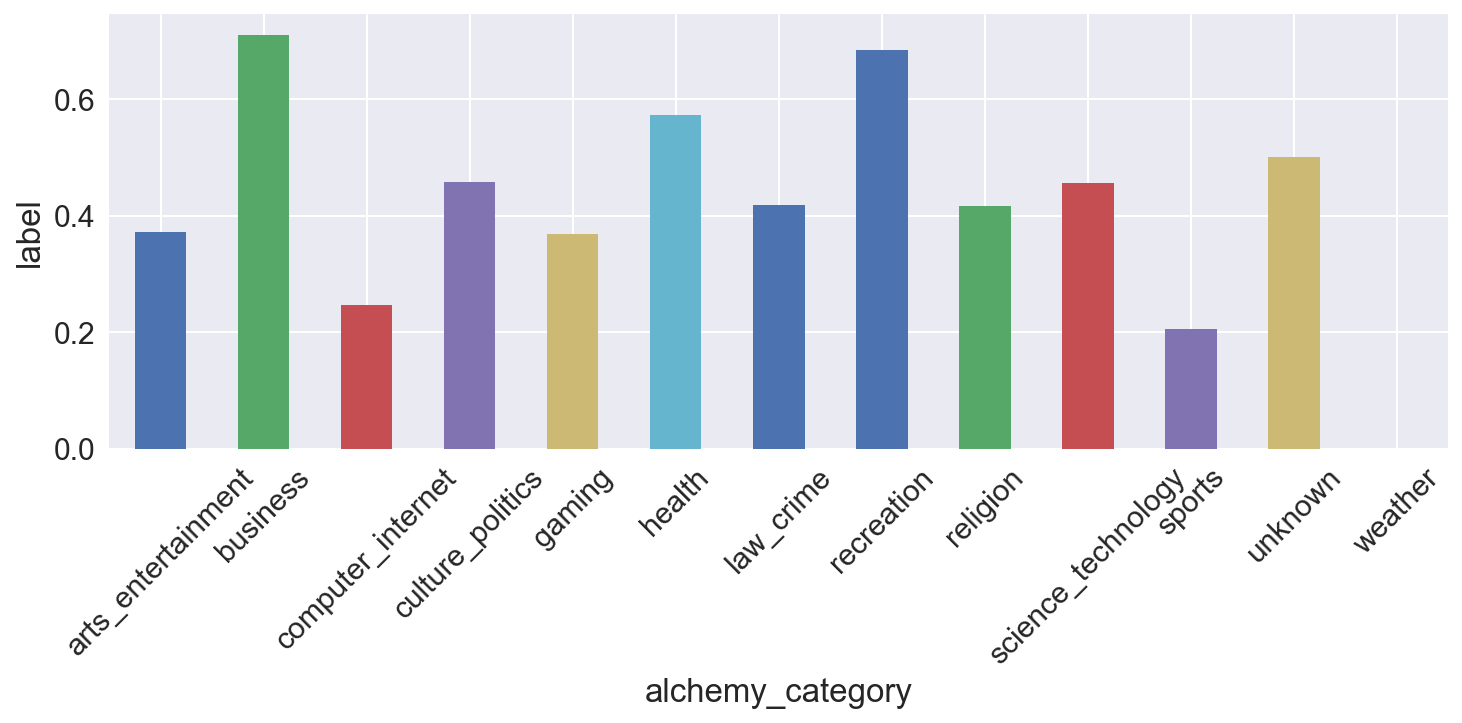

In [14]:
data.groupby('alchemy_category')[['label']].mean().plot(kind='bar',y='label',rot=45,figsize=(12,4),legend=None)
plt.ylabel('label')
plt.show()

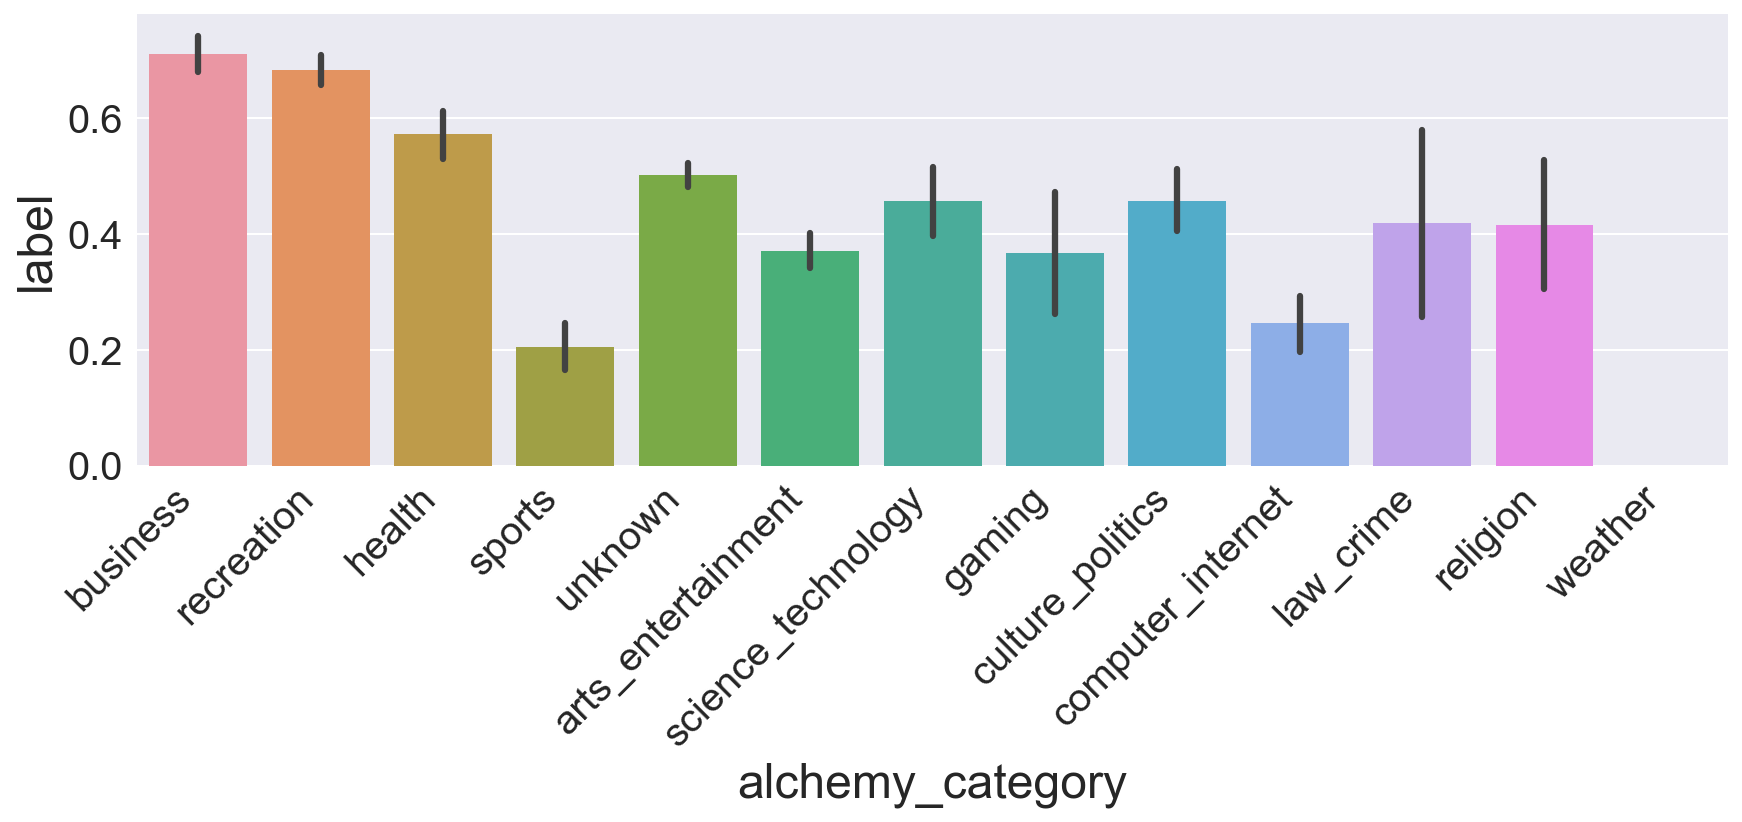

In [15]:
sns.factorplot(x='alchemy_category', y='label', 
               data=data, kind='bar', aspect=3
              ).set_xticklabels(rotation=45, horizontalalignment='right',
              fontsize=20).set_yticklabels(fontsize=20)
plt.xlabel('alchemy_category',fontsize=24)
plt.ylabel('label',fontsize=24)
plt.show()

#### 4.B Test the hypothesis with a logistic regression.

The `C` in the statsmodels formula declares the variables as being categorical. `Treatment` declares which of the categories defines the reference level. 

The default solver has convergence problems here. You can choose different solvers when calling the fit method. Check out the options at [statsmodels logistic regression](http://statsmodels.sourceforge.net/devel/generated/statsmodels.discrete.discrete_model.Logit.fit.html).

In [16]:
cat_model = smf.logit("label ~ C(alchemy_category,Treatment(reference='weather'))", 
                     data=data).fit(method='ncg')
cat_model.summary()

Optimization terminated successfully.
         Current function value: 0.649499
         Iterations: 9
         Function evaluations: 10
         Gradient evaluations: 18
         Hessian evaluations: 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  label   No. Observations:                 7395
Model:                          Logit   Df Residuals:                     7382
Method:                           MLE   Df Model:                           12
Date:                Tue, 17 Jul 2018   Pseudo R-squ.:                 0.06249
Time:                        11:11:25   Log-Likelihood:                -4803.0
converged:                       True   LL-Null:                       -5123.2
                                        LLR p-value:                2.593e-129
=============================================================================================================================================
                                                                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                    -7.2141     18.442     -0.391      0.696     -43.361      28.932
C(alchemy_category, Treatment(reference='weather'))[T.arts_entertainment]     6.6903     18.443      0.363      0.717     -29.457      42.837
C(alchemy_category, Treatment(reference='weather'))[T.business]               8.1162     18.443      0.440      0.660     -28.031      44.263
C(alchemy_category, Treatment(reference='weather'))[T.computer_internet]      6.0974     18.443      0.331      0.741     -30.050      42.245
C(alchemy_category, Treatment(reference='weather'))[T.culture_politics]       7.0446     18.443      0.382      0.702     -29.103      43.192
C(alchemy_category, Treatment(reference='weather'))[T.gaming]                 6.6751     18.444      0.362      0.717     -29.474      42.825
C(alchemy_category, Treatment(reference='weather'))[T.health]                 7.5087     18.443      0.407      0.684     -28.638      43.656
C(alchemy_category, Treatment(reference='weather'))[T.law_crime]              6.8887     18.446      0.373      0.709     -29.265      43.042
C(alchemy_category, Treatment(reference='weather'))[T.recreation]             7.9877     18.443      0.433      0.665     -28.159      44.135
C(alchemy_category, Treatment(reference='weather'))[T.religion]               6.8777     18.444      0.373      0.709     -29.272      43.027
C(alchemy_category, Treatment(reference='weather'))[T.science_technology]     7.0407     18.443      0.382      0.703     -29.107      43.188
C(alchemy_category, Treatment(reference='weather'))[T.sports]                 5.8604     18.443      0.318      0.751     -30.287      42.008
C(alchemy_category, Treatment(reference='weather'))[T.unknown]                7.2209     18.443      0.392      0.695     -28.926      43.368
=============================================================================================================================================
"""

In [17]:
cat_model.params

Intercept                                                                   -7.214136
C(alchemy_category, Treatment(reference='weather'))[T.arts_entertainment]    6.690252
C(alchemy_category, Treatment(reference='weather'))[T.business]              8.116151
C(alchemy_category, Treatment(reference='weather'))[T.computer_internet]     6.097422
C(alchemy_category, Treatment(reference='weather'))[T.culture_politics]      7.044634
C(alchemy_category, Treatment(reference='weather'))[T.gaming]                6.675138
C(alchemy_category, Treatment(reference='weather'))[T.health]                7.508737
C(alchemy_category, Treatment(reference='weather'))[T.law_crime]             6.888712
C(alchemy_category, Treatment(reference='weather'))[T.recreation]            7.987721
C(alchemy_category, Treatment(reference='weather'))[T.religion]              6.877663
C(alchemy_category, Treatment(reference='weather'))[T.science_technology]    7.040691
C(alchemy_category, Treatment(reference='weather'))[T.

#### 4.C Interpret the model results.

Many of the categories appear to have a significant effect on the likelihood of evergreen
status. Note that here the reference category is set to be the category called `unknown`. This is wrapped into
the intercept term. These categories must be interpreted as significantly different from
`unknown` or not.

Positive predictors of evergreen vs. `unknown`:
1. Business
2. Health
3. Recreation

Negative predictors of evergreen vs. `unknown`:
1. Arts and entertainment
2. Computer and internet
3. Gaming
4. Sports

The rest of the categories are not significantly different than the `unknown` category
in their probability of being evergreen or not.

### 5. Does the image ratio affect evergreenness?

#### 5.A Investigate with plots/EDA.

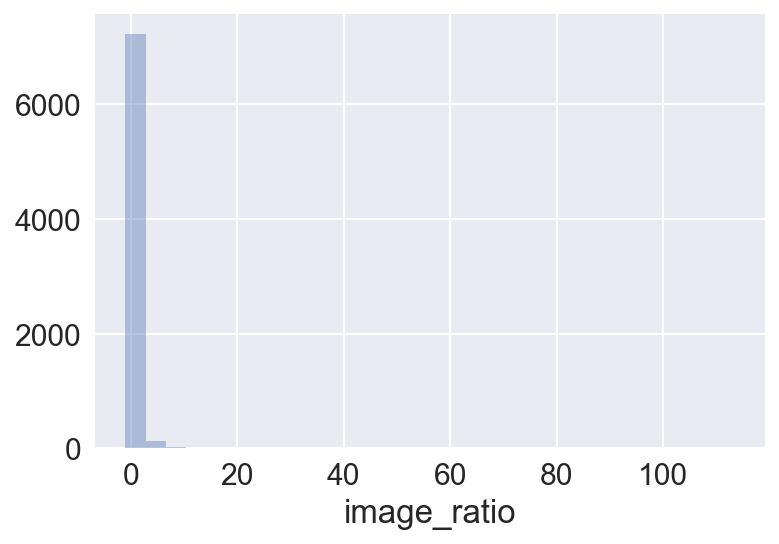

In [18]:
sns.distplot(data.image_ratio, bins=30, kde=False)
plt.show()

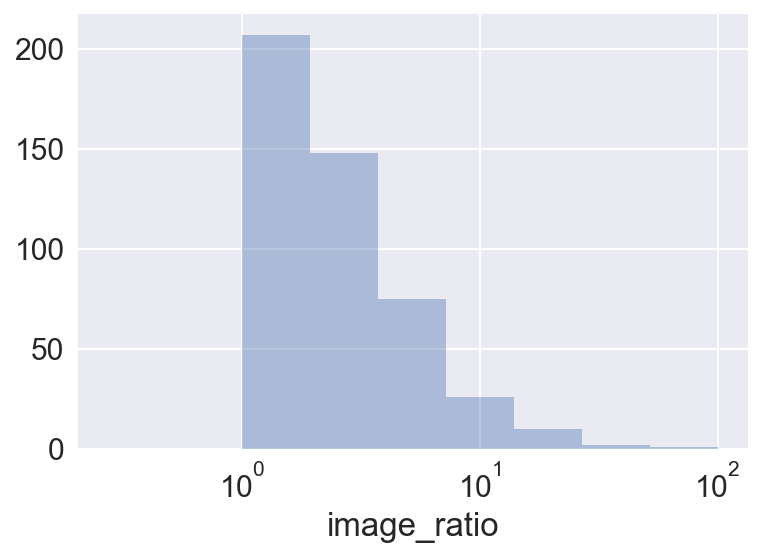

In [19]:
# better presentation with logarithmically scaled x-axis and log-binning
sns.distplot(data.image_ratio, bins=np.logspace(0,2,8), kde=False)
plt.xscale('log')
plt.show()

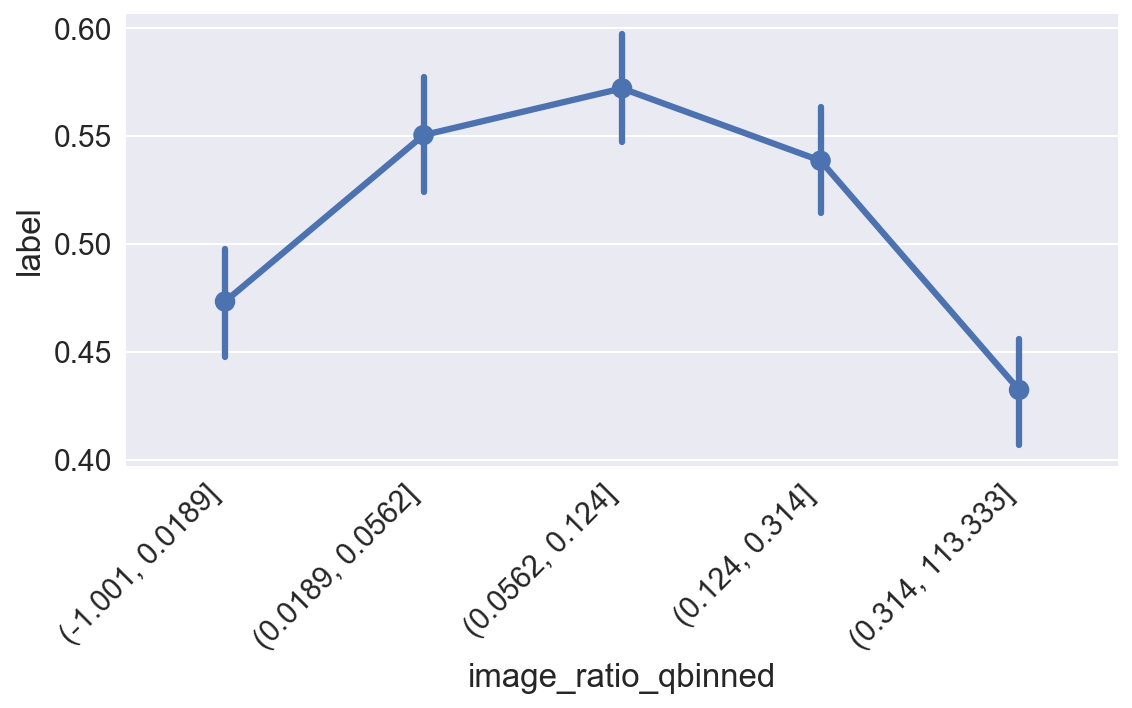

In [20]:
# qcut can divide arrays up by quantile - in this case into 5 bins
data['image_ratio_qbinned'] = pd.qcut(data['image_ratio'], 5)

sns.factorplot('image_ratio_qbinned', 'label', 
               data=data, aspect=2).set_xticklabels(rotation=45, 
                                        horizontalalignment='right')
plt.show()

In [21]:
data.image_ratio_qbinned.value_counts()

(0.124, 0.314]      1480
(0.0562, 0.124]     1479
(0.0189, 0.0562]    1479
(-1.001, 0.0189]    1479
(0.314, 113.333]    1478
Name: image_ratio_qbinned, dtype: int64

In [22]:
data.image_ratio_qbinned[data.label==1].value_counts()/data.image_ratio_qbinned.value_counts()

(-1.001, 0.0189]    0.473293
(0.0189, 0.0562]    0.550372
(0.0562, 0.124]     0.572008
(0.124, 0.314]      0.538514
(0.314, 113.333]    0.432341
Name: image_ratio_qbinned, dtype: float64

#### 5.B Test the hypothesis using a logistic regression.

> **Note**: It is worth thinking about how to best represent this variable. It may not be wise to input the image ratio as-is.

In [23]:
# a model using image ratio alone (ignoring the apparent nonlinear effect and skewed distribution):
image_model = smf.logit("label ~ image_ratio", data=data).fit()
image_model.summary()

Optimization terminated successfully.
         Current function value: 0.692631
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  label   No. Observations:                 7395
Model:                          Logit   Df Residuals:                     7393
Method:                           MLE   Df Model:                            1
Date:                Tue, 17 Jul 2018   Pseudo R-squ.:               0.0002325
Time:                        11:11:27   Log-Likelihood:                -5122.0
converged:                       True   LL-Null:                       -5123.2
                                        LLR p-value:                    0.1228
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.0590      0.024      2.499      0.012       0.013       0.105
image_ratio    -0.0210      0.015     -1.400      0.161      -0.051       0.008
===============================================================================
"""

In [24]:
from sklearn.metrics import accuracy_score
accuracy_score(data.label,1*(image_model.predict(data['image_ratio'])>0.5))

0.5158891142663962

In [25]:
# convert the image ratio to percentiles (this is what qcut is representing in bins):
# you can use the scipy.stats.percentileofscore for this:
from scipy import stats

data['image_ratio_pctl'] = data.image_ratio.map(lambda x: 
                                                stats.percentileofscore(data.image_ratio.values, x))

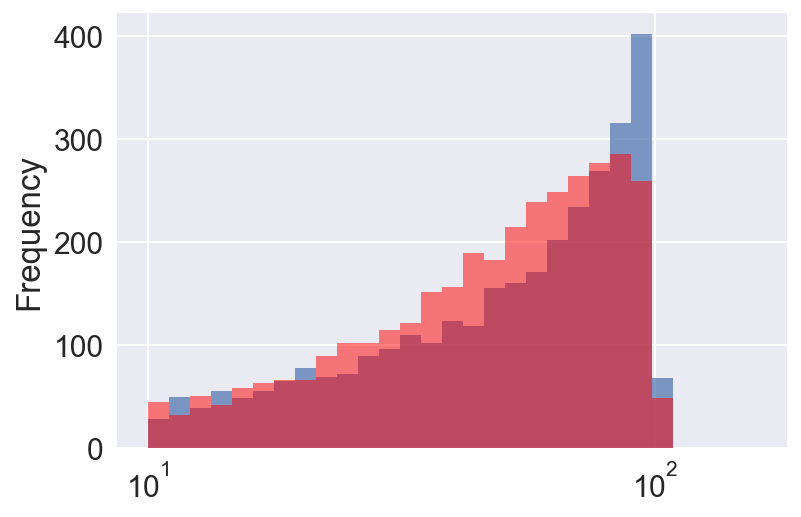

In [26]:
ax = data.loc[data.label==0,'image_ratio_pctl'].plot(kind='hist',bins=np.logspace(1,2.2,30),alpha=0.7, logx=True);
data.loc[data.label==1,'image_ratio_pctl'].plot(kind='hist',bins=np.logspace(1,2.2,30),color='r',alpha=0.5, logx=True, ax=ax);

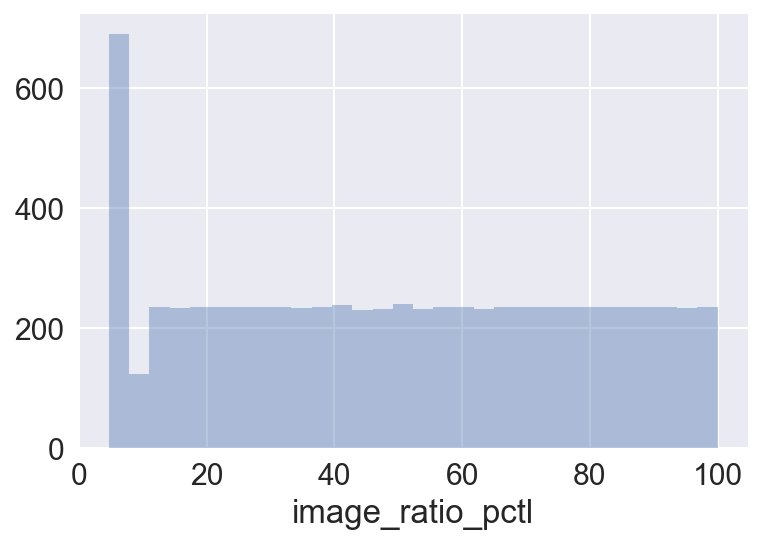

In [27]:
sns.distplot(data.image_ratio_pctl, bins=30, kde=False)
plt.show()

In [28]:
# use the image_ratio_percentile instead
# this is still ignoring the nonlinearity we wee in the plot above!
image_model = smf.logit("label ~ image_ratio_pctl", data=data).fit()
image_model.summary()

Optimization terminated successfully.
         Current function value: 0.692458
         Iterations 3


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  label   No. Observations:                 7395
Model:                          Logit   Df Residuals:                     7393
Method:                           MLE   Df Model:                            1
Date:                Tue, 17 Jul 2018   Pseudo R-squ.:               0.0004832
Time:                        11:11:36   Log-Likelihood:                -5120.7
converged:                       True   LL-Null:                       -5123.2
                                        LLR p-value:                   0.02607
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.1431      0.047      3.070      0.002       0.052       0.234
image_ratio_pctl    -0.0018      0.001     -2.224      0.026      -0.003      -0.000
====================================================================================
"""

In [29]:
accuracy_score(data.label,1*(image_model.predict(data['image_ratio_pctl'])>0.5))

0.5406355645706559

In [30]:
# Fit a model with the percentile and the percentile squared (quadratic effect)
# This will let us model that inverse parabola
# Note: statsmodels formulas can take numpy functions!
image_model = smf.logit("label ~ image_ratio_pctl + np.power(image_ratio_pctl, 2)", data=data).fit()
image_model.summary()

Optimization terminated successfully.
         Current function value: 0.686094
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  label   No. Observations:                 7395
Model:                          Logit   Df Residuals:                     7392
Method:                           MLE   Df Model:                            2
Date:                Tue, 17 Jul 2018   Pseudo R-squ.:                0.009668
Time:                        11:11:36   Log-Likelihood:                -5073.7
converged:                       True   LL-Null:                       -5123.2
                                        LLR p-value:                 3.084e-22
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                        -0.3687      0.071     -5.219      0.000      -0.507      -0.230
image_ratio_pctl                  0.0289      0.003      8.808      0.000       0.022       0.035
np.power(image_ratio_pctl, 2)    -0.0003   3.18e-05     -9.644      0.000      -0.000      -0.000
=================================================================================================
"""

In [31]:
accuracy_score(data.label,1*(image_model.predict(data['image_ratio_pctl'])>0.5))

0.553211629479378

#### 5.C Interpret the model.

Once it's modeled well (convert the image ratio to percentiles and include
a quadratic term) we can see these significant effects:

1. There is a positive effect of the image ratio percentile score (its rank 
across image_ratios)
2. There is a negative quadratic effect of image ratio. That is to say, at
 a certain point the squared term of image_ratio_pctl overtakes the linear
 term. The highest probability of evergreen sites have image ratios in the
 median range.

### 6. Fit a logistic regression with multiple predictors.
- The choice of predictors is up to you. Test features you think may be valuable to predict evergreen status.
- Do any EDA you may need.
- Interpret the coefficients of the model.

> **Tip:** [This pdf is very useful for an overview of interpreting logistic regression coefficients.](https://www.unm.edu/~schrader/biostat/bio2/Spr06/lec11.pdf)

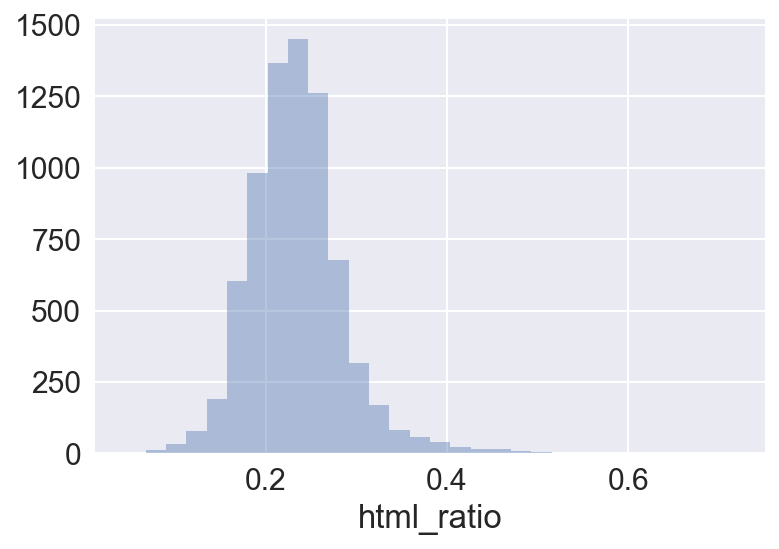

In [32]:
# look at the distribution of html_ratio
sns.distplot(data.html_ratio, bins=30, kde=False)
plt.show()

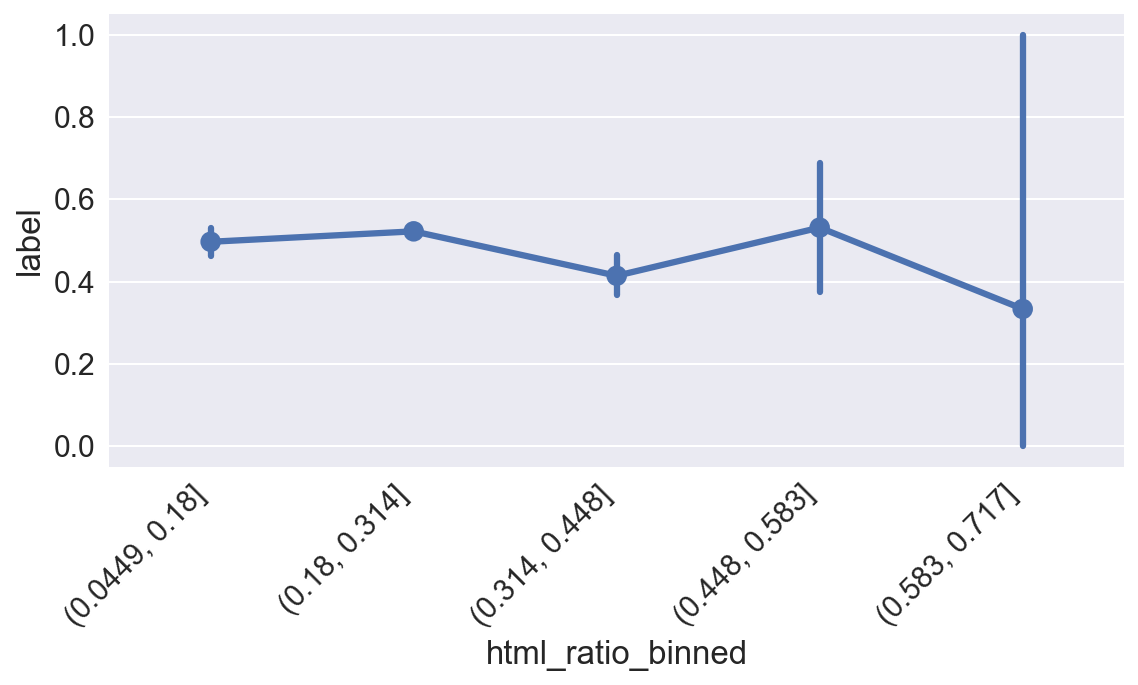

In [33]:
# cut can divide arrays up into linear bins - in this case into 5 bins
data['html_ratio_binned'] = pd.cut(data['html_ratio'], 5)
sns.factorplot('html_ratio_binned', 'label', data=data, aspect=2
              ).set_xticklabels(rotation=45, horizontalalignment='right')
plt.show()

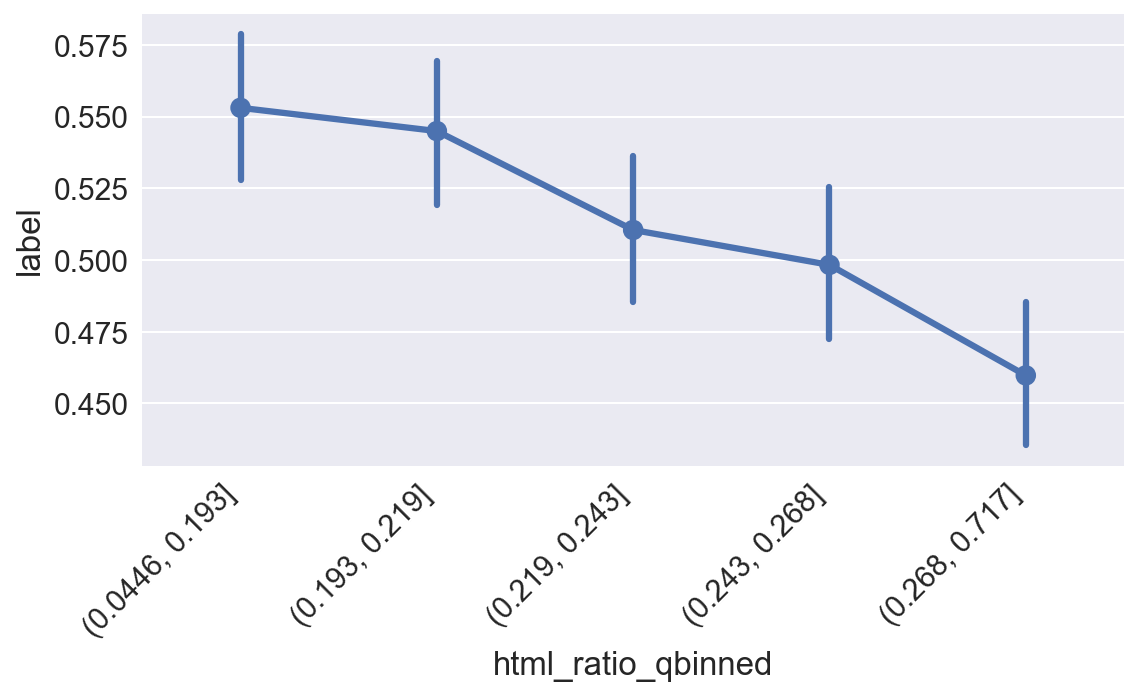

In [34]:
# cut can divide arrays up into quantile based bins - in this case into 5 bins
data['html_ratio_qbinned'] = pd.qcut(data['html_ratio'], 5)
sns.factorplot('html_ratio_qbinned', 'label', data=data, aspect=2
              ).set_xticklabels(rotation=45, horizontalalignment='right')
plt.show()

In [35]:
data.html_ratio_qbinned[data.label==1].value_counts()/data.html_ratio_qbinned.value_counts()

(0.0446, 0.193]    0.553076
(0.193, 0.219]     0.544963
(0.219, 0.243]     0.510480
(0.243, 0.268]     0.498310
(0.268, 0.717]     0.459770
Name: html_ratio_qbinned, dtype: float64

In [36]:
data['html_ratio_pctl'] = data.html_ratio.map(lambda x: stats.percentileofscore(data.html_ratio.values, x))

In [37]:
# You can see scipy puts percentiles from 0-100: important for interpreting coefs
data.html_ratio_pctl.head()

0    63.029074
1    26.747803
2    46.085193
3    78.417850
4    48.275862
Name: html_ratio_pctl, dtype: float64

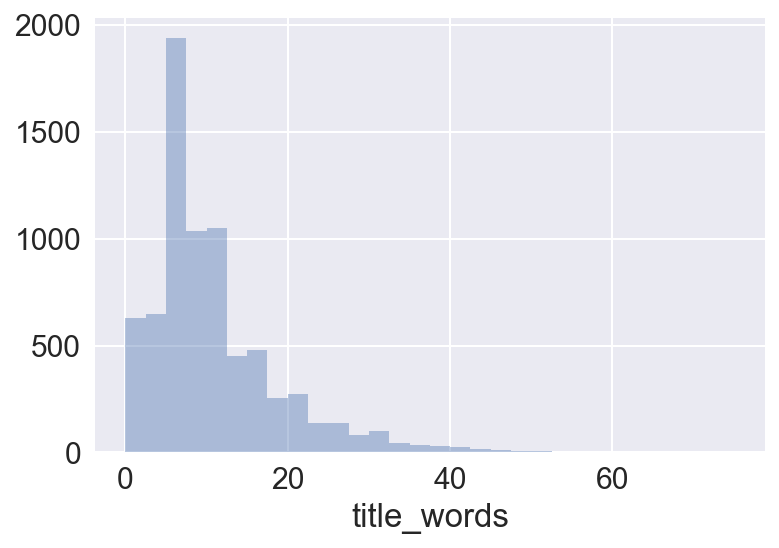

In [38]:
def title_len(x):
    try:
        return len(x.split())
    except:
        return 0.

# calculate the number of words in the title and plot distribution
data['title_words'] = data.title.map(title_len)
sns.distplot(data.title_words, bins=30, kde=False)
plt.show()

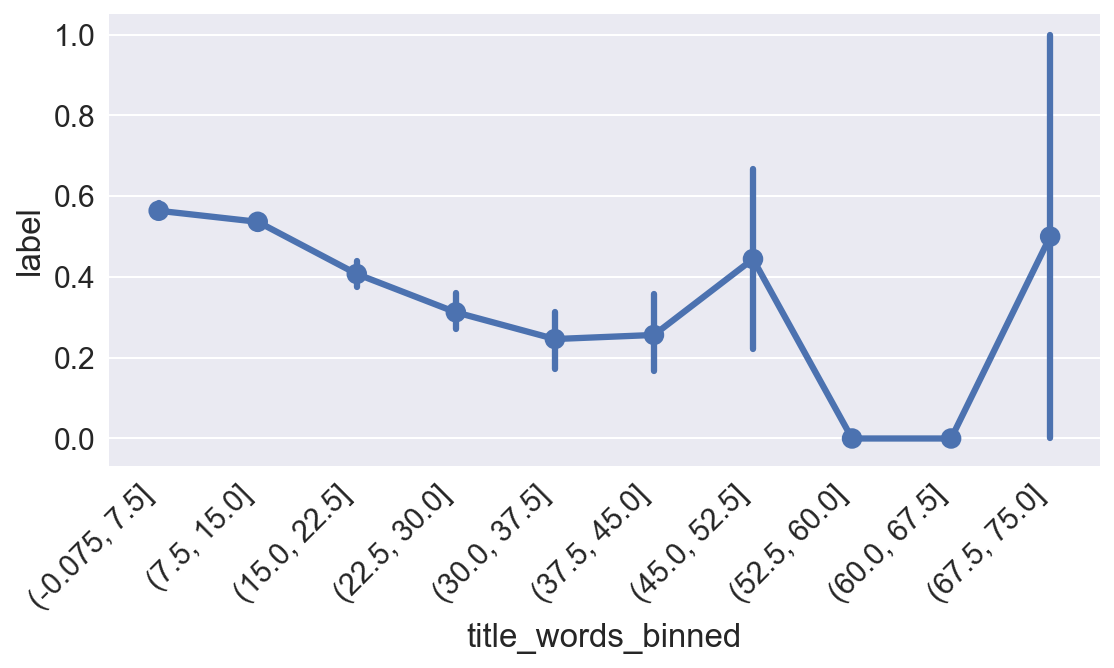

In [39]:
data['title_words_binned'] = pd.cut(data['title_words'], 10)

sns.factorplot('title_words_binned', 'label', data=data, aspect=2
              ).set_xticklabels(rotation=45, horizontalalignment='right')
plt.show()

In [40]:
data.title_words_binned[data.label==1].value_counts()/data.title_words_binned.value_counts()

(-0.075, 7.5]    0.563959
(7.5, 15.0]      0.536576
(15.0, 22.5]     0.407407
(22.5, 30.0]     0.312500
(30.0, 37.5]     0.246269
(37.5, 45.0]     0.256410
(45.0, 52.5]     0.444444
(52.5, 60.0]     0.000000
(60.0, 67.5]     0.000000
(67.5, 75.0]     0.500000
Name: title_words_binned, dtype: float64

In [41]:
# Build a model with the image ratio percentile, html ratio, and title length
f = '''
label ~ image_ratio_pctl + np.power(image_ratio_pctl, 2) + html_ratio_pctl + title_words
'''
model = smf.logit(f, data=data).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.667797
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  label   No. Observations:                 7395
Model:                          Logit   Df Residuals:                     7390
Method:                           MLE   Df Model:                            4
Date:                Tue, 17 Jul 2018   Pseudo R-squ.:                 0.03608
Time:                        11:11:48   Log-Likelihood:                -4938.4
converged:                       True   LL-Null:                       -5123.2
                                        LLR p-value:                 9.885e-79
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                         0.3855      0.096      4.015      0.000       0.197       0.574
image_ratio_pctl                  0.0382      0.003     11.181      0.000       0.031       0.045
np.power(image_ratio_pctl, 2)    -0.0004   3.31e-05    -12.514      0.000      -0.000      -0.000
html_ratio_pctl                  -0.0078      0.001     -8.438      0.000      -0.010      -0.006
title_words                      -0.0446      0.003    -13.928      0.000      -0.051      -0.038
=================================================================================================
"""

In [42]:
# exponentiate the coefficients to get the odds ratio:
np.exp(model.params)

Intercept                        1.470349
image_ratio_pctl                 1.038888
np.power(image_ratio_pctl, 2)    0.999585
html_ratio_pctl                  0.992222
title_words                      0.956410
dtype: float64

We've got all significant effects on our predictors here.
We can interpret the results as odds ratios.
1. for a 1 percentile increase in image_ratio, there is a ~1.04 increase in the odds of evergreen
2. for a 1 unit increase in image_ratio_pctl**2, there is a ~1
increase in the odds of evergreen
3. for a 1 percentile increase in html_ratio, there is a ~0.99 increase in the odds of evergreen
4. for a 1 word increase in the length of the title, there is a ~0.96 increase in the odds of evergreen